In [6]:
# %% [markdown]
# # ⚗️ 2. Advanced Model Training & Optimization
# **Goal:** Find the absolute best model for Carbonic Anhydrase Drug Discovery.
# **Approach:**
# 1. Generate Features (Morgan Fingerprints + Protein Metadata).
# 2. Build a Sklearn Pipeline (Scaler + Model).
# 3. Screen 8+ Algorithms (XGBoost, CatBoost, RF, etc.).
# 4. Tune the Champion Model.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Modelling & Pipelines
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [7]:
# Chemistry
from rdkit import Chem
from rdkit.Chem import AllChem

# Plot styling
sns.set_style("whitegrid")
%matplotlib inline

In [8]:
# ## 1. Load the Clean Data
# We load the file we prepared in the previous notebook.

data_path = '../artifacts/data/clean_training_data.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"✅ Loaded Clean Data: {df.shape}")
    print(f"   Columns: {df.columns.tolist()}")
else:
    print("❌ Error: 'clean_training_data.csv' not found. Please run Notebook 1 again.")

✅ Loaded Clean Data: (8825, 7)
   Columns: ['clean_smiles', 'target_name', 'pIC50', 'Protein_Hydrophobicity', 'Protein_Weight', 'Protein_Isoelectric', 'Protein_Aromaticity']


In [9]:

df = pd.read_csv("../artifacts/data/clean_training_data.csv")

In [10]:
df.head()

,clean_smiles,target_name,pIC50,Protein_Hydrophobicity,Protein_Weight,Protein_Isoelectric,Protein_Aromaticity
0,Brc1cc(CN2CCCCC2)cc(Br)c1OCCCN1CCCCC1,CA IV,8.118466,-0.343910,35031.9265,7.684825,0.080128
1,Brc1ccc(C(c2nnnn2Cc2ccccc2)N2CCCN(C3CCC3)CC2)cc1,CA IV,6.939302,-0.343910,35031.9265,7.684825,0.080128
2,Brc1ccc(OCc2ccc(CN3CCCCC3)cc2)cc1,CA IV,6.943095,-0.343910,35031.9265,7.684825,0.080128
3,Brc1ccc2[nH]c3c(c2c1)CCN(CC(c1ccccc1)c1ccccc1)...,CA IX,5.065502,-0.356645,49697.2476,4.637232,0.056645
4,Brc1ccc2[nH]nc(-c3ccccc3)c2c1,CA IX,5.500000,-0.356645,49697.2476,4.637232,0.056645


In [11]:
# --- Helper: Fingerprint Generator ---
def get_fingerprints(smiles_list, n_bits=2048):
    """Converts SMILES to numpy array of bit vectors"""
    fps = []
    valid_indices = []
    print(f"Generating ECFP4 Fingerprints for {len(smiles_list)} molecules...")
    
    for i, smiles in enumerate(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
                fps.append(np.array(fp))
                valid_indices.append(i)
        except:
            continue
    return np.array(fps), valid_indices

In [12]:
# 1. Generate X (Features)
X_fps, valid_idx = get_fingerprints(df['clean_smiles'])
X_fps_df = pd.DataFrame(X_fps, columns=[f'fp_{i}' for i in range(2048)])

# 2. Get Protein Features (The Context)
# Note: We exclude 'Protein_Instability' to avoid errors
protein_cols = ['Protein_Weight', 'Protein_Aromaticity', 'Protein_Isoelectric', 'Protein_Hydrophobicity']
X_protein = df.iloc[valid_idx][protein_cols].reset_index(drop=True)


Generating ECFP4 Fingerprints for 8825 molecules...


[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerator
[14:54:22] DEPRECATION WARNING: please use MorganGenerat

In [13]:
# 3. Combine All Features
X = pd.concat([X_fps_df, X_protein], axis=1)

# 4. Get Target (pIC50)
Y = df.iloc[valid_idx]['pIC50'].values

print(f"🔹 Final Dataset Shape: {X.shape}")

🔹 Final Dataset Shape: (8825, 2052)


In [14]:
# %% [markdown]
# ## 2. Train-Test Split & Data Pipeline
# We separate the data to ensure we don't "cheat" during training.

# Split 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"Train Size: {X_train.shape[0]} | Test Size: {X_test.shape[0]}")

Train Size: 7060 | Test Size: 1765


In [15]:
# --- Creating the Transformer Pipeline ---
# We want to Scale the Protein features, but leave the Binary Fingerprints alone.

numerical_cols = protein_cols
# Fingerprint columns are already 0/1, so we don't scale them
binary_cols = [c for c in X.columns if c.startswith('fp_')]

# Numerical Pipeline (Scaling)
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# The Full Preprocessor
preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_cols),
    ('pass_through', 'passthrough', binary_cols) # Don't touch fingerprints
])

print("✅ Pipeline Constructed.")

✅ Pipeline Constructed.


In [16]:
# %% [markdown]
# ## 3. Model Selection (The "Battle Royale")
# We test many models to see which one understands Chemistry best.

# %% [markdown]
# ## 3. Model Selection (Robust Fix)
# We pre-process the data ONCE, then train models directly to avoid library conflicts.

# 1. Fit & Transform Data Manually
print("⚙️ Pre-processing data...")
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# 2. Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.01),
    "Ridge": Ridge(),
    "K-Neighbors": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "XGBoost": XGBRegressor(n_jobs=-1),
    "CatBoost": CatBoostRegressor(verbose=False),
    "AdaBoost": AdaBoostRegressor()
}

results = []
print("🚀 Starting Model Evaluation...\n")

for name, model in models.items():
    try:
        # Train directly on processed data (Bypasses Pipeline error)
        model.fit(X_train_proc, y_train)
        
        # Predict
        y_pred = model.predict(X_test_proc)
        
        # Score
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({'Model': name, 'R2': r2, 'MAE': mae, 'RMSE': rmse})
        print(f"✅ {name:20} -> R2: {r2:.4f} | MAE: {mae:.4f}")
        
    except Exception as e:
        print(f"❌ {name} Failed: {str(e)}")

# Convert to DataFrame for visualization
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)




⚙️ Pre-processing data...
🚀 Starting Model Evaluation...

✅ Linear Regression    -> R2: 0.6001 | MAE: 0.6981
✅ Lasso                -> R2: 0.4760 | MAE: 0.8188
✅ Ridge                -> R2: 0.6479 | MAE: 0.6582
✅ K-Neighbors          -> R2: 0.7549 | MAE: 0.5027
✅ Decision Tree        -> R2: 0.6209 | MAE: 0.5768
✅ Random Forest        -> R2: 0.7830 | MAE: 0.4623
✅ XGBoost              -> R2: 0.7408 | MAE: 0.5323
✅ CatBoost             -> R2: 0.7511 | MAE: 0.5298
✅ AdaBoost             -> R2: 0.2979 | MAE: 1.0232


C:\Users\prabh\AppData\Local\Temp\ipykernel_17588\1484329263.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='R2', y='Model', palette='viridis')


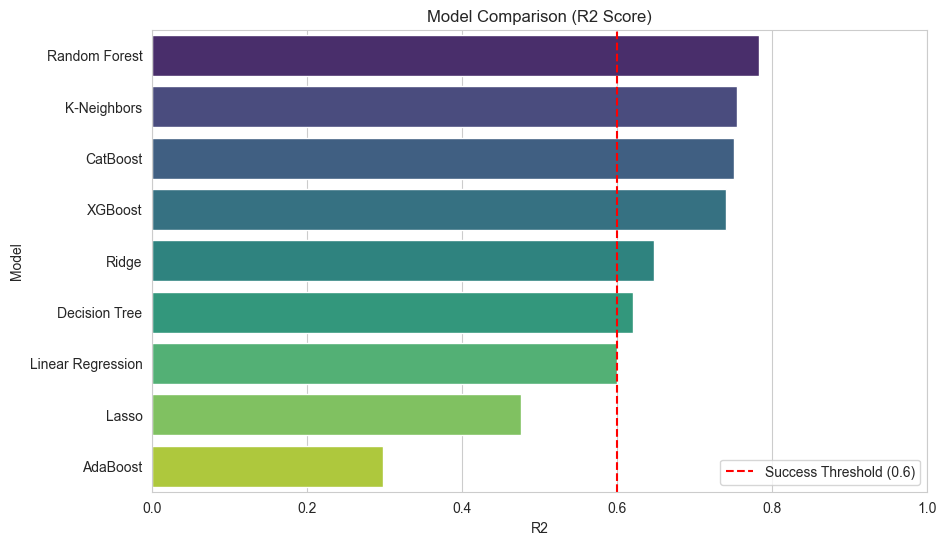

,Model,R2,MAE,RMSE
5,Random Forest,0.782966,0.462319,0.684229
3,K-Neighbors,0.754887,0.502732,0.727144
7,CatBoost,0.751133,0.529761,0.732692
6,XGBoost,0.740829,0.532293,0.747706
2,Ridge,0.647884,0.658196,0.871526
4,Decision Tree,0.620865,0.576792,0.904345
0,Linear Regression,0.600058,0.698071,0.928830
1,Lasso,0.476009,0.818786,1.063162
8,AdaBoost,0.297916,1.023185,1.230643


In [17]:
# %% [markdown]
# ## 4. Visualize Results
# Which model won?

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='R2', y='Model', palette='viridis')
plt.title("Model Comparison (R2 Score)")
plt.xlim(0, 1)
plt.axvline(0.6, color='r', linestyle='--', label='Success Threshold (0.6)')
plt.legend()
plt.show()

display(results_df)

In [25]:
# ## 5. Save for Docking
# We save this high-accuracy model for the pipeline.

joblib.dump(final_model, '../artifacts/model.pkl')
joblib.dump(preprocessor, '../artifacts/preprocessor.pkl')

print("💾 Model restored and saved to 'artifacts/model.pkl'.")

💾 Model restored and saved to 'artifacts/model.pkl'.
